# Chapter 15: Inter-Agent Communication (A2A)

개별 AI 에이전트는 고급 기능을 갖추고 있더라도, 복잡하고 다면적인 문제를 해결할 때 한계를 겪는 경우.  

**A2A** 은 서로 다른 프레임워크로 구축되었을 수도 있는 다양한 AI 에이전트가 효과적으로 협업해 다면적인 문제를 해결하게 해 줍다.  
협업에는 원활한 조정(seamless coordination), 작업 위임(task delegation), 정보 교환(information exchange)이 포함된다.

**Google의 A2A 프로토콜**은 이러한 보편적인 커뮤니케이션을 지원하기 위해 설계된 **open standard** 다.

## Inter-Agent Communication 패턴 개요

**Agent2Agent(A2A) 프로토콜**은 상호 운용성을 보장하여, LangGraph, CrewAI, Google ADK와 같은 기술로 개발된 AI 에이전트들이 **어떤 출처나 프레임워크 차이가 있더라도 함께 동작**할 수 있도록 한다.

A2A는 Atlassian, Box, LangChain, MongoDB, Salesforce, SAP, ServiceNow 등  
다양한 기술 기업과 서비스 제공업체들이 지원하고 있습니다.  

또한 Microsoft는 A2A를 **Azure AI Foundry**와 **Copilot Studio**에 통합할 계획을 가지고 있어,  
오픈 프로토콜에 대한 강한 의지를 보여주고 있습니다.  

Auth0와 SAP 역시 자사 플랫폼과 에이전트에 A2A 지원을 통합하고 있다.

## A2A의 핵심 개념 (Core Concepts of A2A)

A2A 프로토콜은 에이전트 간 상호작용을 위한 **구조화된 접근 방식**을 제공한다.

A2A의 기본적인 구성 요소(기둥)는 다음과 같습니다.  
- Core Actors  
- Agent Card  
- Agent Discovery  
- Communication and Tasks  
- Interaction Mechanisms  
- Security  


---

## Core Actors

A2A에는 세 가지 주요 엔티티가 등장합니다.

- **User(사용자)**: 에이전트의 도움을 요청하는 주체입니다.
- **A2A Client (Client Agent)**: 사용자를 대신하여 액션이나 정보를 요청하는 애플리케이션 또는 AI 에이전트입니다.
- **A2A Server (Remote Agent)**: HTTP 엔드포인트를 제공해 클라이언트 요청을 처리하고 결과를 반환하는 AI 에이전트 또는 시스템입니다.  
  원격 에이전트는 클라이언트가 내부 동작 방식을 알 필요가 없는 **“불투명(opaque)” 시스템**으로 동작합니다.

---

## Agent Card

에이전트의 디지털 정체성은 보통 **JSON 파일 형태의 Agent Card**로 정의됩니다.  
이 파일에는 다음과 같은, 클라이언트 상호작용과 자동 발견에 필요한 핵심 정보가 포함됩니다.

- 에이전트의 이름, 설명, 버전
- 엔드포인트 URL
- 스트리밍, 푸시 알림과 같은 지원 기능(capabilities)
- 제공하는 스킬(기능) 목록
- 기본 입력/출력 모드
- 인증 방식 및 요구 사항

WeatherBot에 대한 Agent Card 예시

```json
{
  "name": "WeatherBot",
  "description": "Provides accurate weather forecasts and historical data.",
  "url": "http://weather-service.example.com/a2a",
  "version": "1.0.0",
  "capabilities": {
    "streaming": true,
    "pushNotifications": false,
    "stateTransitionHistory": true
  },
  "authentication": {
    "schemes": ["apiKey"]
  },
  "defaultInputModes": ["text"],
  "skills": [
    {
      "id": "get_current_weather",
      "name": "Get Current Weather",
      "description": "Retrieve real-time weather for any location.",
      "inputModes": ["text"],
      "outputModes": ["text"],
      "examples": [
        "What's the weather in Paris?",
        "Current conditions in Tokyo"
      ],
      "tags": ["weather", "current", "real-time"]
    },
    {
      "id": "get_forecast",
      "name": "Get Forecast",
      "description": "Get 5-day weather predictions.",
      "inputModes": ["text"],
      "outputModes": ["text"],
      "examples": [
        "5-day forecast for New York",
        "Will it rain in London this weekend?"
      ],
      "tags": ["weather", "forecast", "prediction"]
    }
  ]
}

## Agent Discovery

**에이전트 디스커버리(Agent discovery)**는 클라이언트가 사용 가능한 A2A 서버들의 **Agent Card를 찾아낼 수 있도록** 해 주는 메커니즘이다. 

Agent Card에는 해당 에이전트가 제공하는 기능들이 기술되어 있다. 제공을 위한 대표적인 전략들은 다음과 같다.

- **Well-Known URI**  

  에이전트가 표준화된 경로(예: `/.well-known/agent.json`)에 Agent Card를 호스팅하는 방식.  
  이 접근 방식은 퍼블릭 또는 도메인별 활용에서 **폭넓고 자동화된 접근성**을 제공하는 데 유리함

- **Curated Registries(큐레이션된 레지스트리)**  

  중앙화된 카탈로그에 Agent Card를 등록해 두고, 특정 기준에 따라 질의·검색할 수 있도록 하는 방식.  
  이는 **중앙 집중식 관리와 접근 제어가 필요한 엔터프라이즈 환경**에 적합함.

- **Direct Configuration(직접 구성)**  

  Agent Card 정보가 애플리케이션에 내장되거나, 사적으로 공유되는 방식.  
  이 방법은 **긴밀히 결합된 시스템**이나 **프라이빗 환경**처럼 동적인 디스커버리가 크게 중요하지 않은 경우에 적합함.

어떤 방식을 사용하든, **Agent Card 엔드포인트를 안전하게 보호하는 것**이 중요.  
보호가 필요한 정보가 포함된 경우,  
접근 제어, **mTLS(mutual TLS)**, 네트워크 레벨 제한 등의 방법을 통해 보안 강화가 필요하다.

## Communications and Tasks

A2A 프레임워크에서 **커뮤니케이션은 비동기 태스크(asynchronous task)**를 중심으로 설계된다.  

태스크는 **오래 걸릴 수 있는 작업을 나타내는 기본 단위**로

- 각 태스크에는 고유한 ID가 있다.  
- 태스크는 `submitted`(요청됨), `working`(처리 중), `completed`(완료됨) 같은 상태를 차례대로 거치게 된다.  

이 구조 덕분에, 여러 태스크를 동시에 실행하는 **병렬 처리**가 가능함.

에이전트끼리 실제로 데이터를 주고받을 때는 **Message(메시지)**를 사용한다.

### Message 구조

메시지는 크게 두 부분으로 구성됨.

- **attributes**  
  메시지를 설명하는 **키-값 형태의 메타데이터**  
  예를 들어, 우선순위, 생성 시각 등

- **parts**  
  실제 내용(payload)을 담는 부분
  예를 들어, 일반 텍스트, 파일, JSON 형태의 구조화된 데이터 등

### Artifacts(결과 산출물)

에이전트가 태스크를 처리하면서 만들어내는 **실제 결과물**을 A2A에서는 **artifact(아티팩트)**라고 한다.

- 아티팩트도 메시지처럼 하나 이상의 `parts`로 구성.  
- 긴 작업의 경우, 결과를 전부 다 만든 뒤 한 번에 보내는 대신  
  **스트리밍 형태로 조금씩 나눠서 보내는 것**도 가능.  
  (예: 긴 보고서를 문단 단위로 순차 전송)

### 통신 프로토콜과 컨텍스트 관리

- 모든 A2A 통신은 **HTTP(S)** 위에서 이루어진다.  
- 요청·응답의 데이터 포맷은 **JSON-RPC 2.0** 규격을 따른다.

또한 여러 번의 요청과 응답이 이어지는 과정에서 **맥락(context)을 유지**하기 위해  
서버는 `contextId`를 발급해 사용한다.

- 같은 `contextId`를 가진 태스크들은 **서로 연결된 하나의 흐름**으로 취급.  
- 덕분에 에이전트는 “이전 대화/작업의 연장선”이라는 것을 이해하고 처리.

## Interaction Mechanisms: 상호작용 메커니즘

A2A는 다양한 AI 애플리케이션 요구사항을 충족하기 위해 여러 가지 **상호작용 방식**을 제공한다.  

- **Synchronous Request/Response (동기 요청/응답)**  

  빠르고 즉시 처리 가능한 작업용    
  클라이언트가 요청을 보내고, 서버가 작업을 처리해 **완전한 응답을 한 번에** 반환할 때까지 대기.  
  하나의 동기 호출로 요청과 응답이 모두 완료.

- **Asynchronous Polling (비동기 폴링)**  

  처리 시간이 오래 걸리는 작업용      
  클라이언트가 요청을 보내면, 서버는 곧바로 `"working"` 상태와 함께 **task ID**를 반환.  
  이후 클라이언트는 다른 일을 하다가, 필요할 때 주기적으로 서버에 폴링 요청을 보내  
  해당 태스크가 `"completed"` 또는 `"failed"` 상태가 되었는지 확인.

- **Streaming Updates (Server-Sent Events, SSE)**  

  **실시간 또는 점진적인 결과**를 받아야 하는 작업용  
  서버에서 클라이언트로 향하는 **단방향(persistent) 연결**을 유지하며,  
  원격 에이전트가 상태 변경, 중간 결과 등의 업데이트를 **지속적으로 푸시**할 수 있다.  
  클라이언트가 계속해서 여러 요청을 보낼 필요가 없다.

- **Push Notifications (Webhooks)**  
  매우 오래 걸리거나 리소스를 많이 사용하는 작업용  
  지속적인 연결 유지나 잦은 폴링이 비효율적일 때,  
  클라이언트는 자신의 **웹훅 URL**을 등록해 두고,  
  서버는 태스크 상태에 의미 있는 변화가 있을 때(예: 완료 시) 해당 URL로 **비동기 알림(push)** 전송.

어떤 방식을 지원하는지는 **Agent Card**에 명시.  
A2A는 **모달리티에 독립적(modality-agnostic)**이므로,  
텍스트뿐 아니라 **오디오, 비디오 등 다양한 데이터 타입**에도  
동일한 상호작용 패턴(스트리밍, 푸시 알림 등)을 적용할 수 있다.

## 동기 요청 예시 (Synchronous Request Example)

동기 요청에서는 클라이언트가 `sendTask` 메서드를 사용해 **질문을 보내고, 단일 완전 응답**을 기대함

```json
{
  "jsonrpc": "2.0",
  "id": "1",
  "method": "sendTask",
  "params": {
    "id": "task-001",
    "sessionId": "session-001",
    "message": {
      "role": "user",
      "parts": [
        {
          "type": "text",
          "text": "What is the exchange rate from USD to EUR?"
        }
      ]
    },
    "acceptedOutputModes": ["text/plain"],
    "historyLength": 5
  }
}

## 스트리밍 요청 예시 (Streaming Request Example)

스트리밍 요청에서는 sendTaskSubscribe 메서드를 사용해
지속적인 연결을 맺고, 여러 번에 걸쳐 부분 결과를 전달받을 수 있다

```json
{
  "jsonrpc": "2.0",
  "id": "2",
  "method": "sendTaskSubscribe",
  "params": {
    "id": "task-002",
    "sessionId": "session-001",
    "message": {
      "role": "user",
      "parts": [
        {
          "type": "text",
          "text": "What's the exchange rate for JPY to GBP today?"
        }
      ]
    },
    "acceptedOutputModes": ["text/plain"],
    "historyLength": 5
  }
}
```

이 방식에서는 에이전트가

- 먼저 대략적인 정보나 상태 업데이트를 보내고,
- 이후 더 정확한 값이나 추가 정보를 차례로 스트리밍하는 식으로    

여러 개의 부분 응답을 시간에 따라 순차적으로 보낼 수 있다.

## Security

### Inter-Agent Communication (A2A)

**Inter-Agent Communication (A2A)**는 시스템 아키텍처에서 매우 중요한 구성 요소로,  
에이전트들 간에 **안전하고 매끄러운 데이터 교환**을 가능하게 한다.  
A2A는 여러 내장 메커니즘을 통해 **견고함(robustness)**과 **무결성(integrity)**을 보장한다.

---

### Mutual Transport Layer Security (TLS)

- A2A에서는 상호 TLS(mTLS)를 통해 **암호화되고 인증된 연결**을 설정한다.  
- 이를 통해 **무단 접근**과 **데이터 가로채기(interception)**를 방지하며,  
  에이전트 간 통신이 안전하게 이루어지도록 한다.

---

### Comprehensive Audit Logs (포괄적인 감사 로그)

- 모든 인터 에이전트 통신은 **정교하게 기록**된다.  
- 여기에는 정보 흐름, 관련된 에이전트, 수행된 액션 등의 정보가 포함된다.  
- 이러한 **감사 로그(audit trail)**는  
  - 책임 추적(accountability),  
  - 문제 해결(troubleshooting),  
  - 보안 분석(security analysis)에 매우 중요하다.

---

### Agent Card Declaration (Agent Card를 통한 선언)

- **인증 요구사항(authentication requirements)**은 Agent Card에 명시적으로 선언된다.  
- Agent Card는 에이전트의  
  - 정체성(identity),  
  - 제공 기능(capabilities),  
  - 보안 정책(security policies)을 기술하는 **구성 아티팩트(configuration artifact)**다.  
- 이를 통해 인증 관련 설정을 **중앙에서 관리**하고, **인증 관리 과정을 단순화**할 수 있다.

---

### Credential Handling (자격 증명 처리)

- 에이전트는 일반적으로 **OAuth 2.0 토큰**, **API 키**와 같은 안전한 자격 증명을 사용해 인증한다.
- 이러한 자격 증명은 **HTTP 헤더**를 통해 전달됨
- 이 방식은  
  - URL이나 메시지 본문에 자격 증명이 노출되는 것을 방지하여  
  - 전체적인 **보안 수준을 강화**함.

## A2A vs. MCP

**A2A**는 Anthropic의 **Model Context Protocol(MCP)**을 보완하는 프로토콜이다.

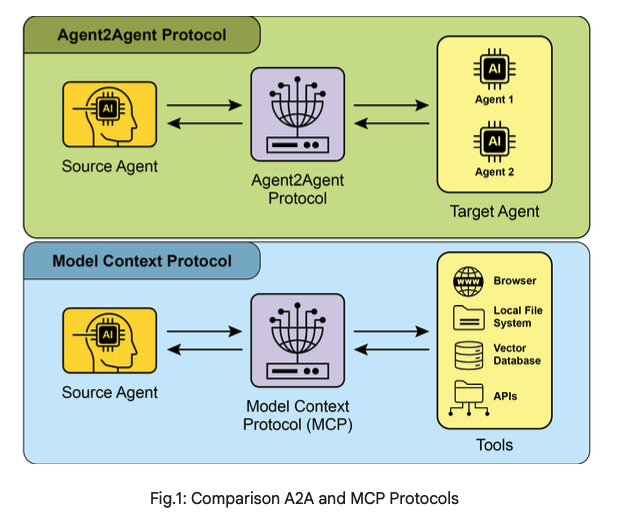

MCP가 에이전트와 외부 데이터·도구 간 상호작용을 위해 **컨텍스트를 구조화하는 것**에 초점을 맞춘다면,  

A2A는 에이전트들 사이의 조정(coordination)과 통신(communication)을 담당하며,  

이를 통해 작업 위임(task delegation)과 협업(collaboration)을 가능하게 한다.

### A2A의 목표

- 효율성 향상  
- 통합(integration) 비용 절감  
- 복잡한 멀티 에이전트 AI 시스템 개발에서  
  혁신과 상호운용성(interoperability)의 촉진

## Practical Applications & Use Cases

- **Multi-Framework Collaboration (멀티 프레임워크 협업)**  

  A2A의 핵심 사용 사례는, **서로 다른 프레임워크(예: ADK, LangChain, CrewAI 등)** 위에서 동작하는  
  독립적인 AI 에이전트들이 서로 **통신하고 협업할 수 있도록 하는 것**이다.  

- **Automated Workflow Orchestration (자동화된 워크플로 오케스트레이션)**  

  에이전트들 간에 태스크를 **위임하고 조율**함으로써 복잡한 워크플로를 구현할 수 있게 해준다.  

  1) 한 에이전트가 초기 데이터 수집을 담당하고,  
  2) 다른 에이전트가 그 데이터를 분석하며,  
  3) 마지막 에이전트가 보고서를 생성하는 식으로  
  세 에이전트가 모두 A2A 프로토콜을 통해 서로 통신하며 협업할 수 있다.

- **Dynamic Information Retrieval (동적 정보 조회)**  

  에이전트들은 서로 통신하며 **실시간 정보**를 조회·교환할 수 있다.  
  예를 들어, 
  
  메인 에이전트가 전문적인 **“데이터 페칭 에이전트(data fetching agent)”**에게  
  실시간 시장 데이터를 요청하고,  
  요청 받은 에이전트는 외부 API를 사용해 데이터를 수집한 뒤 다시 메인 에이전트에게 전달하는 방식.

In [1]:
import os
from dotenv import load_dotenv

import datetime
from typing import List, Dict, Any

from langchain.agents import create_agent
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI

In [2]:
load_dotenv()

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
GEMINI_MODEL = "gemini-2.5-flash"

llm = ChatGoogleGenerativeAI(
    api_key=GEMINI_API_KEY,
    model=GEMINI_MODEL,
    temperature=0.3,
)


In [3]:
DUMMY_EVENTS: List[Dict[str, Any]] = []

In [4]:
@tool
def create_dummy_event(
    title: str,
    start_datetime: str,
    end_datetime: str,
    description: str = "",
) -> str:
    """
    더미 캘린더에 새 일정을 추가합니다.

    매개변수:
    - title: 일정 제목
    - start_datetime: 시작 시각 (RFC3339 또는 ISO8601 문자열 가정)
    - end_datetime: 종료 시각 (RFC3339 또는 ISO8601 문자열 가정)
    - description: 일정 설명(선택)
    """
    event = {
        "title": title,
        "start": start_datetime,
        "end": end_datetime,
        "description": description,
    }
    DUMMY_EVENTS.append(event)

    return (
        "다음 일정이 더미 캘린더에 추가되었습니다.\n"
        f"- 제목: {title}\n"
        f"- 시작: {start_datetime}\n"
        f"- 종료: {end_datetime}\n"
        f"- 설명: {description or '(없음)'}\n"
        f"(현재 총 {len(DUMMY_EVENTS)}개의 더미 일정이 저장됨)"
    )

@tool
def list_dummy_events() -> str:
    """
    더미 캘린더에 저장된 모든 일정을 한국어 텍스트로 반환합니다.
    """
    if not DUMMY_EVENTS:
        return "더미 캘린더에 저장된 일정이 없습니다."

    lines = ["더미 캘린더에 저장된 일정 목록:"]
    for idx, event in enumerate(DUMMY_EVENTS, start=1):
        lines.append(
            f"{idx}. 제목: {event['title']}\n"
            f"   시작: {event['start']}\n"
            f"   종료: {event['end']}\n"
            f"   설명: {event['description'] or '(없음)'}"
        )
    return "\n".join(lines)

@tool
def clear_dummy_events() -> str:
    """
    더미 캘린더에 저장된 모든 일정을 삭제합니다.
    """
    count = len(DUMMY_EVENTS)
    DUMMY_EVENTS.clear()
    return f"더미 캘린더에서 {count}개의 일정을 모두 삭제했습니다."

In [5]:
def create_calendar_agent():
    tools = [create_dummy_event, list_dummy_events, clear_dummy_events]

    now = datetime.datetime.now().isoformat()

    system_prompt = f"""
당신은 '더미 캘린더'를 관리하는 에이전트입니다.

- 이 에이전트는 실제 Google Calendar API와 통신하지 않습니다.
- 대신, 프로세스 메모리에만 일정을 저장하고 조회하는 더미 도구들을 사용합니다.
- 사용자는 실제 캘린더처럼 질문하지만, 모든 결과는 테스트/데모용 가상의 데이터입니다.

역할:
1. 사용자의 요청을 이해하고,
2. 필요할 때 더미 캘린더 도구(create_dummy_event, list_dummy_events, clear_dummy_events)를 호출하여
   일정을 생성/조회/삭제하며,
3. 최종적으로 결과를 한국어로 차분하고 명확하게 설명합니다.

규칙:
- 사용자가 특별히 언어를 바꾸어 달라고 요청하지 않는 한, 항상 한국어로 대답하십시오.
- 날짜/시간 표현(예: '오늘 오후 3시', '내일 오전 10시부터 2시간')은
  현재 시각({now})을 기준으로 해석하고,
  도구를 호출할 때는 ISO8601/RFC3339 형식 문자열로 정리해서 넘기도록 노력하십시오.
- 더미 캘린더는 이 프로세스가 살아 있는 동안에만 유지되며,
  재시작하면 모든 일정이 사라질 수 있음을 사용자에게 필요 시 알려주십시오.

당신의 목표는:
- 사용자가 '실제 캘린더를 다루는 것과 유사한 경험'을 느끼면서도,
- 이 시스템이 테스트/데모용 더미 캘린더라는 점을 적절히 안내하는 것입니다.
"""

    agent = create_agent(
        model=llm,
        tools=tools,
        system_prompt=system_prompt,
        name="DummyCalendarAgent",
    )
    return agent

In [6]:
agent = create_calendar_agent()

response = agent.invoke(
    {
        "messages": [
            (
                "user",
                "다음 주 화요일 오후 3시에 '팀 미팅' 일정을 추가해줘. 설명은 '프로젝트 진행 상황 공유'야."
            )
        ]
    }
)

print(response)

{'messages': [HumanMessage(content="다음 주 화요일 오후 3시에 '팀 미팅' 일정을 추가해줘. 설명은 '프로젝트 진행 상황 공유'야.", additional_kwargs={}, response_metadata={}, id='b251823c-406b-469b-b2a9-47654c0a0d91'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'create_dummy_event', 'arguments': '{"start_datetime": "2025-12-02T15:00:00", "end_datetime": "2025-12-02T16:00:00", "description": "\\ud504\\ub85c\\uc81d\\ud2b8 \\uc9c4\\ud589 \\uc0c1\\ud669 \\uacf5\\uc720", "title": "\\ud300 \\ubbf8\\ud305"}'}, '__gemini_function_call_thought_signatures__': {'e960823d-dc1a-4b9a-9e86-a85f6e05094b': 'CsMFAXLI2nzISNGLBmF+ywYsiR0duYRpzo6GQOLybuWv7xZ7qLTcdTtWoEFCtUZEAtqvlnEvMhYnGeLMTuR7CjFpvUb37PUyLDh9raS53BWFjvzfmd7ll0NYG0dzEhfqh9xZNf19c96EfwoeZu4qo/t8V2m392zkFPTY4pRXHB2wH86ag2F8C1Nen81TKdg2atbkQPk9vcMAvgLwBTNkMjW2rxs+N4d5i0WyL9HfTKno1CBWDoGTbGiht7nz02b0uRw4oXM2d0zh6KVUPlCd2ZUS89vMNbPWts+q+60Xr3ng/CZQbrEDlJ63TqfpD2LypZCO5HoU6JjfCqiMOt+15nMZhFLa2Ufh2CM74bmXBJTtMGQ04tWdGljTxSbJYvHvNeSc79uSXnproCBfI1AGHvhRZe1BGWKc

In [7]:
print(response["messages"][-1].content)

네, 다음 주 화요일(2025년 12월 2일) 오후 3시부터 4시까지 '팀 미팅' 일정이 더미 캘린더에 추가되었습니다. 설명은 '프로젝트 진행 상황 공유'입니다.

이 캘린더는 테스트/데모용이며, 이 프로세스가 재시작되면 모든 일정이 사라질 수 있습니다.


In [9]:
import argparse
import os

import uvicorn

from a2a.server.agent_execution import AgentExecutor, RequestContext
from a2a.server.events import EventQueue
from a2a.server.apps import A2AStarletteApplication
from a2a.server.request_handlers import DefaultRequestHandler
from a2a.server.tasks import InMemoryTaskStore
from a2a.types import (
    AgentCapabilities,
    AgentCard,
    AgentSkill,
)
from a2a.utils import new_agent_text_message

In [10]:
class CalenderAgentExecutor(AgentExecutor):
    def __init__(self) -> None:
        self.agent = create_calendar_agent()

    async def execute(
        self,
        context: RequestContext,
        event_queue: EventQueue,
    ) -> None:
        query = context.get_user_input()

        result = self.agent.invoke(
            {
                "messages": [
                    ("user", query)
                ]
            }
        )

        messages = result.get("messages", [])
        if messages:
            last_message = messages[-1]
            result_content = getattr(last_message, "content", "")
        else:
            result_content = "일정을 처리하는 중에 오류가 발생했습니다."

        message = new_agent_text_message(
            text=result_content,
            context_id=context.context_id,
        )
        await event_queue.enqueue_event(message)

    async def cancel(
        self,
        context: RequestContext,
        event_queue: EventQueue,
    ) -> None:
        raise Exception("캘린더 에이전트는 취소를 지원하지 않습니다.")

In [11]:
def build_agent_card(host: str, port: int) -> AgentCard:
    skill = AgentSkill(
        id="calendar-management",
        name="캘린더 관리",
        description="사용자의 일정 생성, 조회, 삭제를 돕는 캘린더 관리 에이전트입니다.",
        tags=["calendar", "scheduling", "productivity"],
        examples=[
            "다음 주 금요일 오전 10시에 '회의' 일정을 추가해줘.",
            "이번 달 내 일정들을 모두 보여줘.",
            "내일 오후 2시에 있는 일정을 삭제해줘.",
        ],
    )

    return AgentCard(
        name="DummyCalendarAgent",
        description="더미 캘린더를 관리하는 에이전트로, 실제 캘린더 API와 통신하지 않고 프로세스 메모리에 일정을 저장하고 조회합니다.",
        url=f"http://{host}:{port}/",
        version="1.0.0",
        defaultInputModes=["text"],
        defaultOutputModes=["text"],
        capabilities=AgentCapabilities(streaming=False),
        skills=[skill],
    )

In [12]:
def create_app(host: str, port: int):
    agent_card = build_agent_card(host, port)

    handler = DefaultRequestHandler(
        agent_executor=CalenderAgentExecutor(),
        task_store=InMemoryTaskStore(),
    )

    app = A2AStarletteApplication(
        agent_card=agent_card,
        http_handler=handler,
    )

    return app.build()

In [15]:
# 스타렛 앱 생성
starlette_app = create_app(host="0.0.0.0", port=8000)

config = uvicorn.Config(
    app=starlette_app,
    host="0.0.0.0",
    port=8000,
    log_level="info",
)

server = uvicorn.Server(config)

await server.serve()

INFO:     Started server process [37711]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:52469 - "GET /.well-known/agent-card.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:52469 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:52492 - "POST / HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [37711]


## At a Glance

### What

개별 AI 에이전트, 특히 **서로 다른 프레임워크 위에 구축된 에이전트들**은  
혼자서 복잡하고 다면적인 문제를 해결하는 데 어려움을 겪는 경우가 많다.  

가장 큰 문제는, 이들이 **효과적으로 소통하고 협업할 수 있는 공통 언어(프로토콜)가 없다**  
이러한 고립 상태 때문에, 여러 특화된 에이전트가 각자의 강점을 결합해  
더 큰 작업을 함께 해결하는 **정교한 시스템을 구축하기가 어렵다.**

표준화된 접근 방식이 없다 보니,  
이질적인 에이전트들을 서로 통합하는 작업은  
- 비용이 많이 들고,  
- 시간이 오래 걸리며,  
- 더 강력하고 응집력 있는 AI 솔루션의 발전을 저해된다.

---

### Why

**Inter-Agent Communication (A2A) 프로토콜**은 이러한 문제를 해결하기 위한  
**오픈·표준화된 솔루션**

- HTTP 기반 프로토콜로 설계되어 있어  
  서로 다른 기술 스택을 사용하는 에이전트들끼리도  
  **상호운용성(interoperability)**을 확보할 수 있다.
- 이를 통해 에이전트들은  
  - 태스크를 조율하고(coordinate),  
  - 작업을 위임하며(delegate tasks),  
  - 정보를 자연스럽게 공유(share information)할 수 있다.

A2A의 핵심 구성 요소 중 하나는 **Agent Card**.  
Agent Card는 에이전트의  
- 능력(capabilities),  
- 스킬(skills),  
- 통신 엔드포인트(communication endpoints)를 기술한 **디지털 정체성 파일**로,  
에이전트 **발견(discovery)**과 **상호작용(interaction)**을 쉽게 만들어 준다.

또한 A2A는  
- 동기(synchronous)·비동기(asynchronous) 통신을 포함한  
  다양한 **상호작용 메커니즘**을 정의하여  
- 여러 종류의 사용 사례를 지원한다.

이처럼 A2A는 에이전트 협업을 위한 **범용 표준**을 제공함으로써,  
복잡한 멀티 에이전트 **Agentic 시스템**을  
모듈형(modular)이고 확장 가능한(scalable) 방식으로 구축할 수 있는 생태계를 조성한다.

---

### Rule of thumb

다음과 같은 상황에서는 이 패턴(A2A 기반 Inter-Agent Communication)을 사용하는 것이 좋다.

- **두 개 이상의 AI 에이전트 간 협업을 오케스트레이션해야 할 때**  
  특히 에이전트들이 서로 다른 프레임워크(예: Google ADK, LangGraph, CrewAI 등)로  
  구현되어 있는 경우에 적합하다.

- **복잡하고 모듈형인 애플리케이션**을 만들고자 할 때  
  예를 들어,  
  - 데이터 분석은 한 에이전트에 위임하고,  
  - 보고서 생성은 다른 에이전트가 담당하는 식으로  
  워크플로의 특정 단계를 **각기 다른 특화 에이전트**에게 맡기는 구조에 이상적

- 한 에이전트가 **다른 에이전트의 능력을 동적으로 발견하고 활용**해야  
  작업을 완수할 수 있는 상황에서도 이 패턴은 필수다.

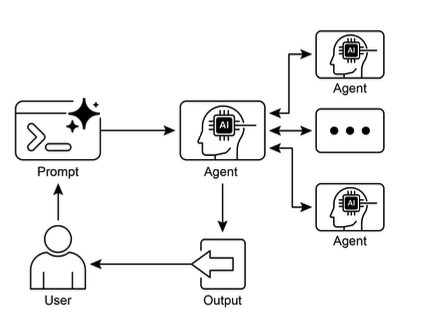

## Key Takeaways

- **Google A2A 프로토콜**은 서로 다른 프레임워크로 구축된 AI 에이전트들 간의  
  **통신과 협업을 가능하게 하는 HTTP 기반 오픈 표준**

- **AgentCard**는 에이전트의 디지털 식별자 역할을 하며,  
  다른 에이전트가 해당 에이전트를 **자동으로 발견**하고  
  그 **능력(capabilities)을 이해**할 수 있도록 도움.

- A2A는 다양한 통신 요구를 충족하기 위해  
  - 동기 요청–응답 방식(`tasks/send`)과  
  - 스트리밍 업데이트 방식(`tasks/sendSubscribe`)  
  두 가지 상호작용 방식을 모두 제공

- 이 프로토콜은 **멀티 턴 대화(multi-turn conversation)**를 지원하며,  
  `input-required` 상태를 통해 에이전트가 **추가 정보 요청**을 할 수 있고,  
  상호작용 과정에서 **맥락(context)을 유지**할 수 있게 해줌.

- A2A는 특화된 에이전트들이 **서로 다른 포트에서 독립적으로 동작**하는  
  **모듈형 아키텍처**를 장려하며, 이를 통해 **시스템 확장성과 분산 처리**를 가능하게 함.

- **Trickle AI**와 같은 도구는 A2A 통신을 시각화하고 추적하는 데 도움을 주어,  
  개발자가 멀티 에이전트 시스템을 **모니터링·디버깅·최적화**에 도움을 줌.

- A2A가 서로 다른 에이전트 간의 **태스크와 워크플로를 관리하기 위한 상위 수준(high-level) 프로토콜**이라면,  
  **Model Context Protocol(MCP)**은 LLM이 외부 리소스와 상호작용하기 위한  
  **표준화된 인터페이스**를 제공.

## Conclusions

**Inter-Agent Communication (A2A) 프로토콜**은 개별 AI 에이전트가 갖는 고립성 문제를 해결하기 위한  
중요한 오픈 표준. A2A는 공통된 **HTTP 기반 프레임워크**를 제공함으로써,  
Google ADK, LangGraph, CrewAI 등 **서로 다른 플랫폼에서 구축된 에이전트들 간의 매끄러운 협업과 상호운용성**을 보장.

A2A의 핵심 구성 요소 중 하나는 **Agent Card**로,  
에이전트의 디지털 정체성(digital identity) 역할을 하며  
에이전트의 기능(capabilities)을 명확히 정의하고  
다른 에이전트가 이를 **동적으로 발견(discovery)**할 수 있게 한다.

또한 이 프로토콜은  
- 동기 요청(synchronous requests),  
- 비동기 폴링(asynchronous polling),  
- 실시간 스트리밍(real-time streaming) 등  
다양한 **상호작용 패턴(interaction patterns)**을 지원하여  
폭넓은 애플리케이션 요구사항을 충족시킬 수 있다.

이를 통해 특화된 에이전트들을 조합하여  
복잡한 자동화 워크플로를 오케스트레이션할 수 있는  
**모듈형(modular)이고 확장 가능한(scalable) 아키텍처**를 구축할 수 있다.

보안 역시 A2A의 핵심 요소로,  
mTLS와 명시적인 인증 요구사항과 같은 내장 메커니즘을 통해  
에이전트 간 통신을 보호.

A2A는 MCP와 같은 다른 표준을 보완하면서도,  
**에이전트 간의 상위 수준(high-level) 조정(coordination)과 태스크 위임(task delegation)**에  
특화된 고유한 역할.

또한 주요 기술 기업들의 강력한 지원과  
실제 구현 사례의 등장으로 그 중요성은 점점 커지고 있다.  
이 프로토콜은 개발자들이 **더 정교하고 분산된, 지능적인 멀티 에이전트 시스템**을 구축할 수 있도록 길을 제시한다.

궁극적으로 A2A는 **혁신적이고 상호운용 가능한 협업형 AI 생태계**를 구축하기 위한  
기초적인 토대(foundation)다.